In [ ]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft

expts = ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]
client = Client(threads_per_worker=1,n_workers = 52)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 52
Total threads: 52,Total memory: 416.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36665,Workers: 52
Dashboard: /proxy/8787/status,Total threads: 52
Started: Just now,Total memory: 416.00 GiB
Comm: tcp://127.0.0.1:41215,Total threads: 1
Dashboard: /proxy/44365/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:44819,


2025-05-01 16:49:45,342 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,356 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,364 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,371 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,378 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,389 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,396 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,405 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,416 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,424 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,434 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,442 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,453 - distributed.nanny - WARNING - Restarting worker
2025-05-01 16:49:45,462 - distributed.

## Plot raw dissipation over long time average

In [2]:
def ShelfMask(data):
    return data.where(
        (data.bathy > -3000) & (data.xb < 200) & (data.bathy < 0),np.nan
    )

def laplacian(data):
    out = data.u.bfill("xb",limit = 4).ffill("xb",limit = 4).differentiate("xb").differentiate("xb")
    out +=data.v.bfill("yb",limit = 4).ffill("yb",limit = 4).differentiate("yb").differentiate("yb")
    return out

def calculate_dissipation(expt,t0,xb = slice(50,250),yb = slice(-80,80),zl = slice(0,4000)):
    with tt.collect_data(
        expt,
        rawdata = ["ahh","u","v"],
        timerange = (t0,t0 + 233 * 50)
        ).sel(xb = xb,yb = yb,zl = zl) as data:
        
        return xr.merge(
            [
            (1034 * 1e-12 * data.ahh * ( ## 1e-12 is conversion from 1/km^2 to 1/m2. (1e-3)^4
                laplacian(data)
                )**2).mean("time").rename("dissipation").load(),
            data.bathy
            ]
        )

# full10 = calculate_dissipation("full-10",22000)
# beamless10 = calculate_dissipation("beamless-10",22000)
# smooth10 = calculate_dissipation("smooth-10",22000)
# full20 = calculate_dissipation("full-20",22000)
# beamless20 = calculate_dissipation("beamless-20",22000)
# smooth20 = calculate_dissipation("smooth-20",22000)
# full40 = calculate_dissipation("full-40",4216)
# beamless40 = calculate_dissipation("beamless-40",4216)
# smooth40 = calculate_dissipation("smooth-40",4216)

# full10.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_full10.nc")
# beamless10.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_beamless10.nc")
# smooth10.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_smooth10.nc")
# full20.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_full20.nc")
# beamless20.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_beamless20.nc")
# smooth20.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_smooth20.nc")
# full40.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_full40.nc")
# beamless40.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_beamless40.nc")
# smooth40.to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/fixed_BC_smooth40.nc")

In [3]:
calculate_dissipation("full-40",1216).to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/longtime_fixed_BC_full40.nc")
calculate_dissipation("beamless-40",1216).to_netcdf("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/longtime_fixed_BC_beamless40.nc")

loading ahh...	done.
loading u...	done.
loading v...	done.
loading ahh...	done.
loading u...	done.
loading v...	done.


In [4]:
data = {}
data["full-40"] = xr.open_dataset("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/longtime_fixed_BC_full40.nc")
data["beamless-40"] = xr.open_dataset("/g/data/nm03/ab8992/postprocessed/shelf_dissipation/longtime_fixed_BC_beamless40.nc")


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


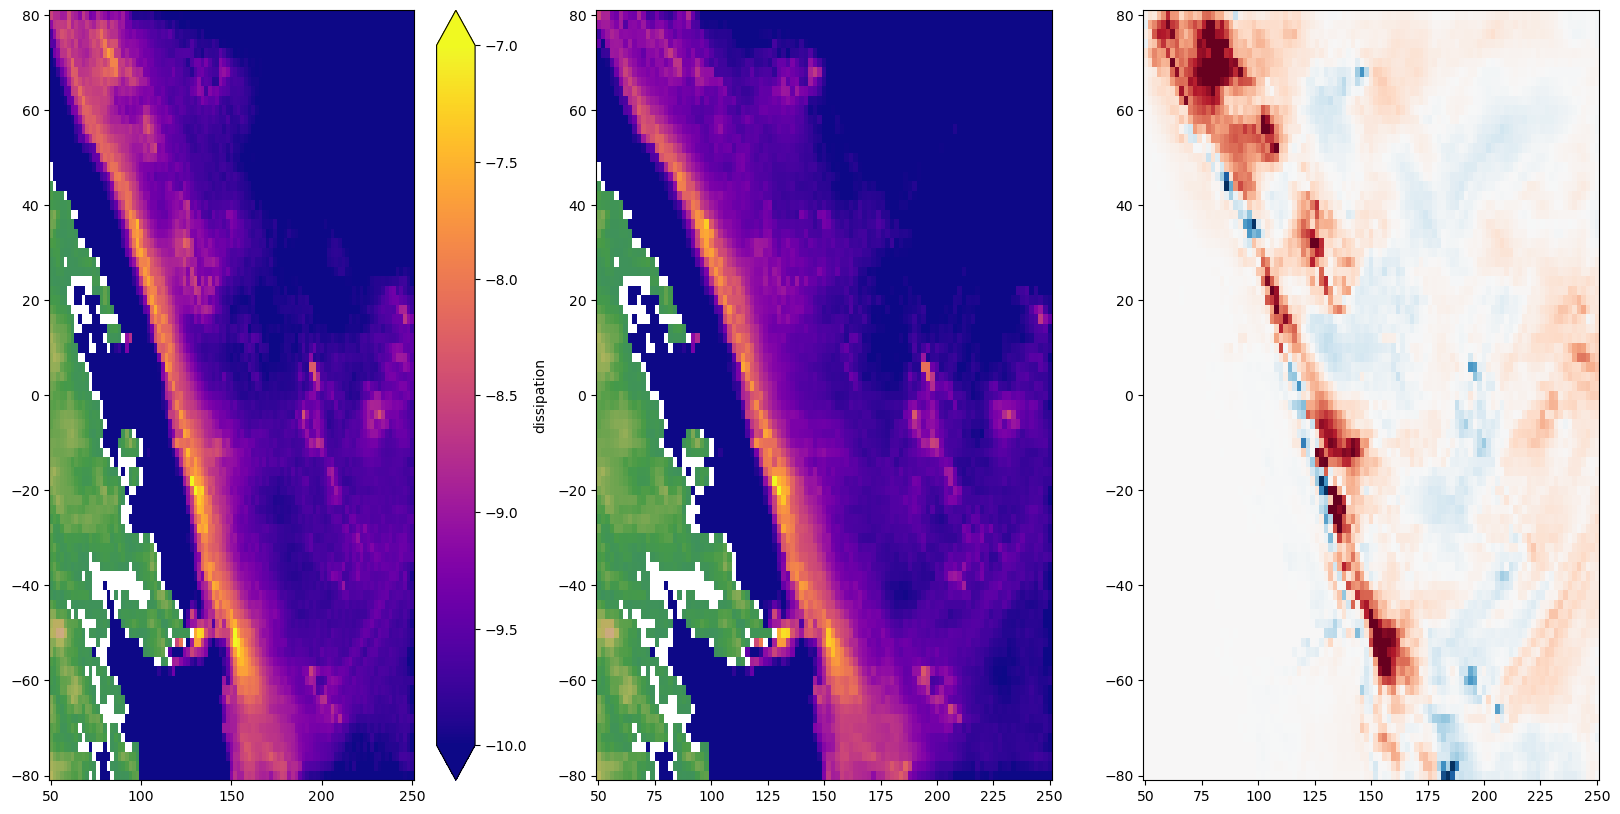

In [56]:
fig,ax = plt.subplots(1,3,figsize=(20,10))

vmin = -10
vmax = -7
vv = 0.0001
cmap = "plasma"
np.log(data["full-40"].dissipation.fillna(0).integrate("zl")).plot(ax = ax[0],add_colorbar = True,vmin = vmin,vmax = vmax,cmap = cmap)
tt.plot_topo(ax[0],data["full-40"].bathy)
np.log(data["beamless-40"].dissipation.fillna(0).integrate("zl")).plot(ax = ax[1],add_colorbar = False,vmin = vmin,vmax = vmax,cmap = cmap)
tt.plot_topo(ax[1],data["full-40"].bathy)

(data["full-40"].dissipation - data["beamless-40"].dissipation).fillna(0).integrate("zl").plot(ax = ax[2],add_colorbar = False,vmin = -1 * vv,vmax = vv,cmap = "RdBu_r")
tt.plot_topo(ax[1],data["full-40"].bathy)

for a in ax:
    a.set_xlabel("")
    a.set_title("")
    a.set_ylabel("")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


0.9229276665012681
0.7900106364871416


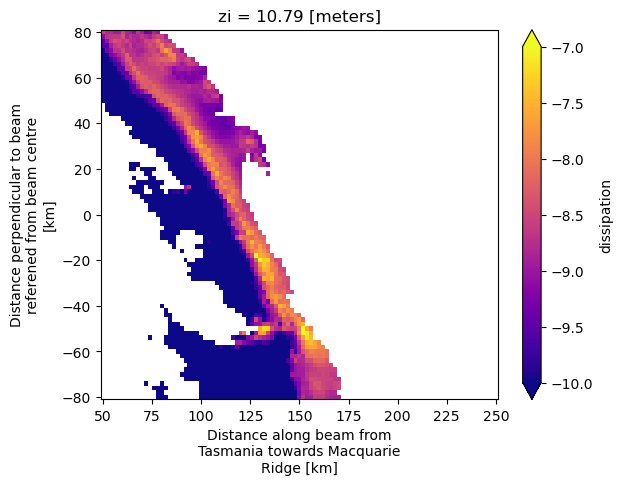

In [67]:
def ShelfMask(data):
    return data.where(
        (data.bathy > -2000) & (data.xb < 200) & (data.bathy < 0),np.nan
    )

np.log(ShelfMask(data["full-40"]).dissipation.fillna(0).integrate("zl")).plot(add_colorbar = True,vmin = vmin,vmax = vmax,cmap = cmap)
# tt.plot_topo(data["full-40"].bathy)
print(ShelfMask(data["full-40"]).fillna(0).dissipation.integrate("zl").integrate("yb").integrate("xb").values)
print(ShelfMask(data["beamless-40"]).fillna(0).dissipation.integrate("zl").integrate("yb").integrate("xb").values)

In [ ]:


for j,i in enumerate(["beamless-40","full-40","smooth-40"]):


    to_plot = ShelfMask(dissipation[i]).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,200)) * 1000 #adjust for density
    # totals[i] = to_plot.mean("xb").mean("yb").values 
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[2,j],add_colorbar = False,vmax = 5e-4,cmap = "plasma")
    tt.plot_topo(ax[2,j],-1 * dissipation["full-40"].bathy)
    ax[2,j].set_ylabel("")
    ax[2,j].set_xlabel("")
    ax[2,j].set_title(f"")

In [7]:

EF_forward = {}
EF_backward = {}
dissipation = {}
KE_modal = {}
for expt in expts:
    EF_forward[expt] = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_forward.nc")
    EF_backward[expt] = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_backward.nc")
    dissipation[expt] = xr.open_dataset(f"/g/data/nm03/ab8992/postprocessed/shelf_dissipation/revised_nofill_{expt.split('-')[0] + expt.split('-')[1]}.nc")
    KE_modal[expt] = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/ke_modal.nc")
    dissipation[expt].bathy[:,:] *= -1



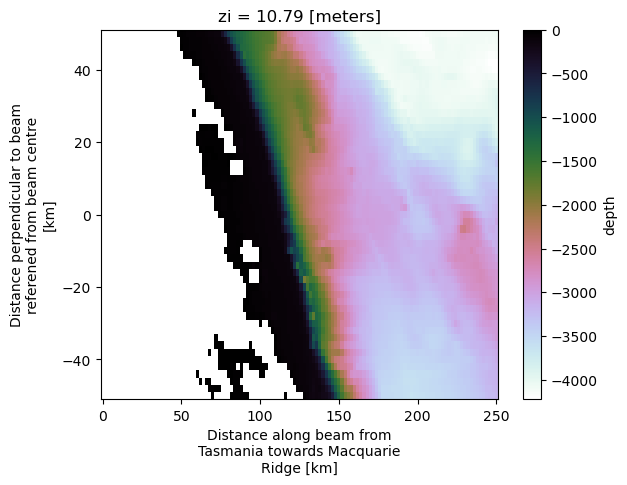

In [63]:
bathy40.where(bathy40 < 0,np.nan).plot(cmap = "cubehelix_r",vmax = 0)

## Same as below but without filling in nans, so lose two points next to topo

/jobfs/135802465.gadi-pbs/ipykernel_2226560/2858206222.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdbu_cmap = matplotlib.cm.get_cmap("RdBu_r")


Experiment          Full from Beamless (%)   Smooth from Full (%)     
----------------------------------------------------------------------
10th:               nan                      nan                      
20th:               nan                      nan                      
40th:               27.3                     149.31                   
----------------------------------------------------------------------
Experiment          Full (mW/m2)             Beamless (mW/m2)         
10th:               nan                      nan                      
20th:               nan                      nan                      
40th:               0.0117                   0.0092                   


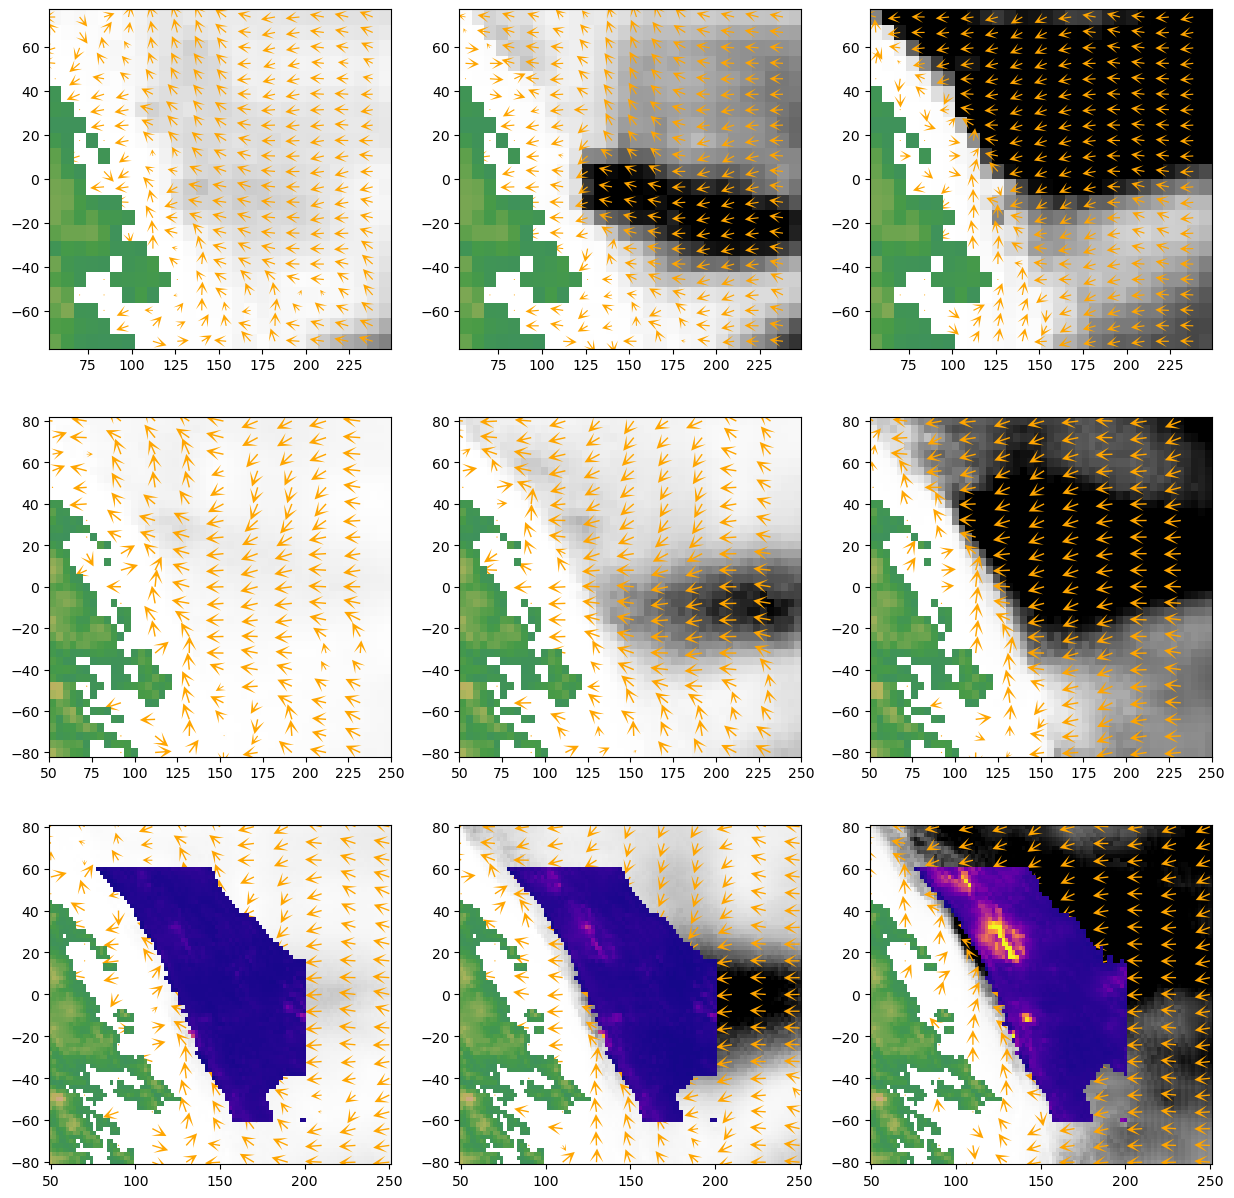

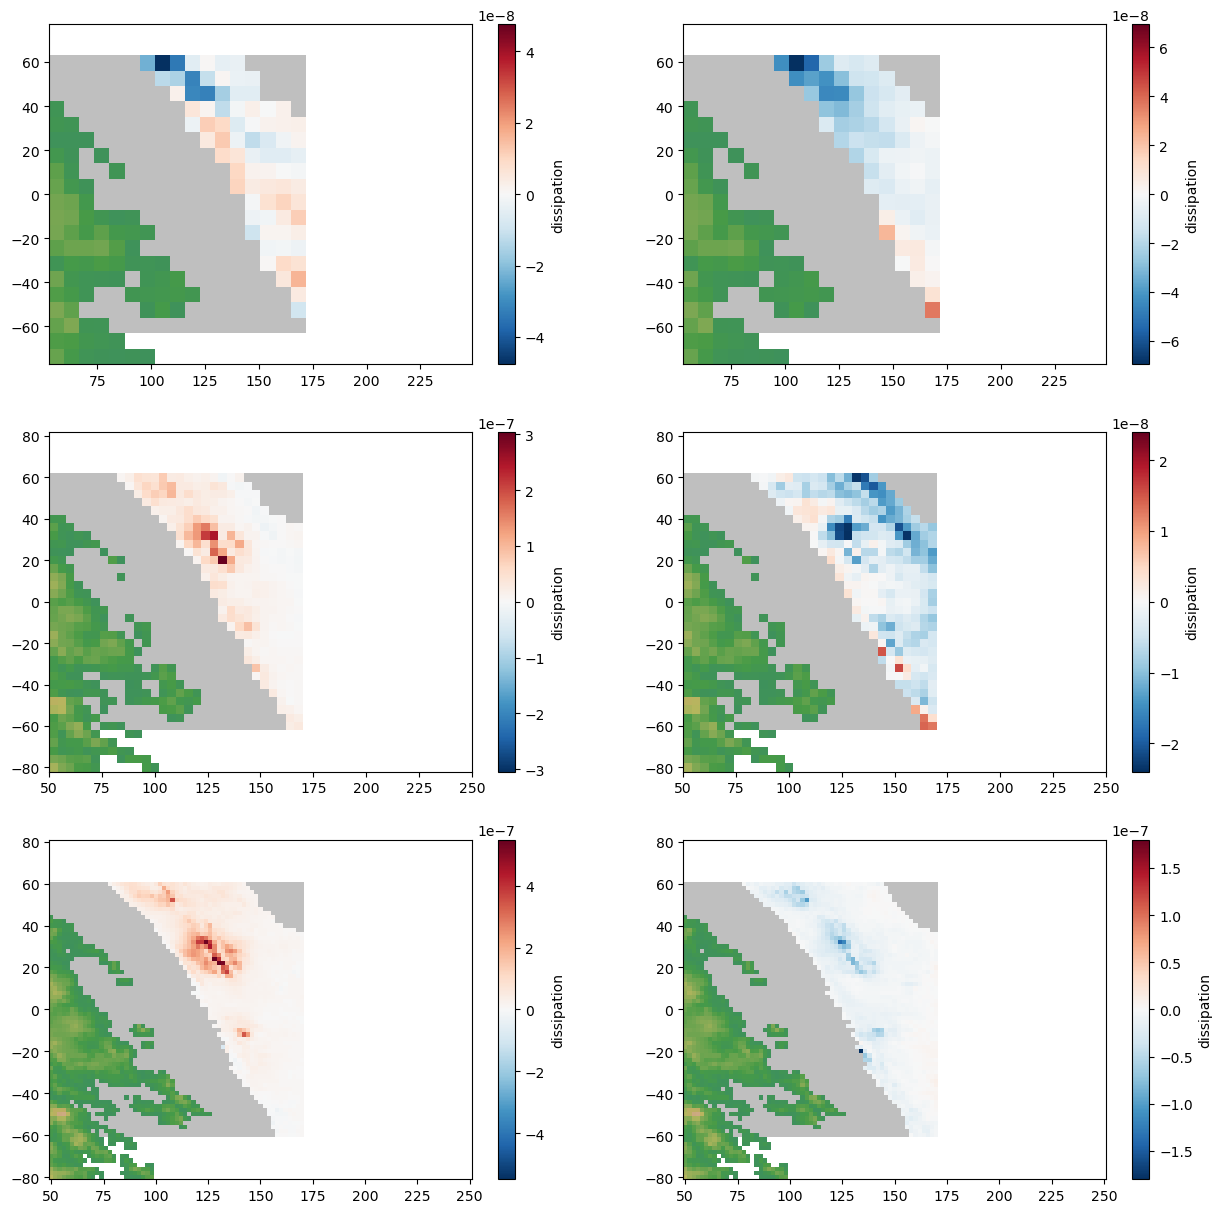

In [ ]:
def ShelfMask(data):
    return data.where(
        ((data.bathy) < 3500) & (data.xb < 1000) & (data.bathy > 200),np.nan
    ).sel(yb = slice(-60,60),zl = slice(1000,None))


def plot_KE_quiver(expt,ax,xlim = slice(50,250),ylim = slice(-80,80)):
    # expt = "full-20"
    alongbeam = -1 * xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_forward.nc").EF_forward + xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_backward.nc").EF_backward
    acrossbeam = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_forward.nc").EF_forward + xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_backward.nc").EF_backward
    alongbeam = alongbeam.sel(xb = xlim,yb = ylim)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim)
    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    magnitude = np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode")

    if "10" in expt:
        vmax = 10
        _yb = acrossbeam.yb[::1]
        _xb = acrossbeam.xb[::2]
        _along = (alongbeam / magnitude).sum("mode")[::1,::2]
        _across = (acrossbeam / magnitude).sum("mode")[::1,::2]
    elif "20" in expt:
        vmax = 60
        _yb = acrossbeam.yb[::2]
        _xb = acrossbeam.xb[::5]
        _along = (alongbeam / magnitude).sum("mode")[::2,::5]
        _across = (acrossbeam / magnitude).sum("mode")[::2,::5]
    elif "40" in expt:
        vmax = 80
        _yb = acrossbeam.yb[::4]
        _xb = acrossbeam.xb[::10]
        _along = 2 * (alongbeam / magnitude).sum("mode")[::4,::10]
        _across = 2 * (acrossbeam / magnitude).sum("mode")[::4,::10]
    # print(expt,np.mean(magnitude.sel(xb = slice(100,175)).values),sep = "\t")

    magnitude.plot(ax = ax,cmap ="Greys",vmax = vmax,add_colorbar = False)
    # print(magnitude)

    ax.quiver(_xb, _yb, _along, _across,color = "orange",headwidth = 10,headlength = 10)
cmap = cmocean.cm.solar
names = ["FULL","SMOOTH","BEAMLESS"]
fig,ax = plt.subplots(3,3,figsize = (15,15))

totals = {}

for j,i in enumerate(["beamless-10","full-10","smooth-10"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    plot_KE_quiver(i,ax[0,j])
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[0,j],vmin = 0,vmax = 10,add_colorbar = True,cmap = "Greys")
    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[0,j],add_colorbar = True,cmap = "Greys_r")
    to_plot = ShelfMask(dissipation[i]).dissipation.integrate("zl").sel(xb = slice(50,200)) * 1000 #adjust for density
    totals[i] = to_plot.mean("xb").mean("yb").values 
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[0,j],add_colorbar = False,vmax = 5e-4,cmap = "plasma")
    tt.plot_topo(ax[0,j],-1 * dissipation["full-10"].bathy)
    ax[0,j].set_title(f"")
    ax[0,j].set_ylabel("")
    ax[0,j].set_xlabel("")
for j,i in enumerate(["beamless-20","full-20","smooth-20"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[1,j],vmin = 0,vmax = 40,add_colorbar = True,cmap = "Greys")
    plot_KE_quiver(i,ax[1,j])

    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[1,j],add_colorbar = True,cmap = "Greys_r")
    to_plot = ShelfMask(dissipation[i]).dissipation.integrate("zl").sel(xb = slice(50,200)) * 1000 #adjust for density
    totals[i] = to_plot.mean("xb").mean("yb").values 
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[1,j],add_colorbar = False,vmax = 5e-4,cmap = "plasma")
    tt.plot_topo(ax[1,j],-1 * dissipation["full-20"].bathy)
    ax[1,j].set_title(f"")
    ax[1,j].set_ylabel("")
    ax[1,j].set_xlabel("")
for j,i in enumerate(["beamless-40","full-40","smooth-40"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[2,j],vmin = 0,vmax = 50,add_colorbar = True,cmap = "Greys")
    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[2,j],add_colorbar = True,cmap = "Greys_r")
    plot_KE_quiver(i,ax[2,j])

    to_plot = ShelfMask(dissipation[i]).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,200)) * 1000 #adjust for density
    totals[i] = to_plot.mean("xb").mean("yb").values 
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[2,j],add_colorbar = False,vmax = 5e-4,cmap = "plasma")
    tt.plot_topo(ax[2,j],-1 * dissipation["full-40"].bathy)
    ax[2,j].set_ylabel("")
    ax[2,j].set_xlabel("")
    ax[2,j].set_title(f"")


rdbu_cmap = matplotlib.cm.get_cmap("RdBu_r")
rdbu_cmap.set_bad(color = "grey",alpha = 0.5)


# names = ["SMOOTH","BEAMLESS"]
# vmax = [0.01,0.002]
# fig,ax = plt.subplots(3,2,figsize = (15,15))
# for j,i in enumerate(["smooth-10","beamless-10"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-10"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     out.where(out != 0,np.nan).plot(ax = ax[0,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[0,j].set_title(f"")
#     ax[0,j].set_ylabel("")
#     ax[0,j].set_xlabel("")
#     ax[0,j].invert_yaxis()
# for j,i in enumerate(["smooth-20","beamless-20"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-20"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     out.where(out != 0,np.nan).plot(ax = ax[1,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[1,j].set_title(f"")
#     ax[1,j].set_ylabel("")
#     ax[1,j].set_xlabel("")
#     ax[1,j].invert_yaxis()
# for j,i in enumerate(["smooth-40","beamless-40"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-40"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     # out.where(out == 0,1).plot(ax = ax[2,j],cmap = "Greys_r")
    
#     out.where(out != 0,np.nan).plot(ax = ax[2,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[2,j].set_ylabel("")
#     ax[2,j].set_xlabel("")
#     ax[2,j].invert_yaxis()
#     ax[2,j].set_title(f"")

names = ["SMOOTH","BEAMLESS"]
vmax = [0.25,0.25]
fig,ax = plt.subplots(3,2,figsize = (15,15))
for j,i in enumerate(["smooth-10","beamless-10"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-10"])).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,170))
    out.where(out != 0,np.nan).plot(ax = ax[0,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[0,j],-1 * dissipation["full-10"].bathy)

    ax[0,j].set_title(f"")
    ax[0,j].set_ylabel("")
    ax[0,j].set_xlabel("")

for j,i in enumerate(["smooth-20","beamless-20"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-20"])).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,170))
    out.where(out != 0,np.nan).plot(ax = ax[1,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[1,j],-1 * dissipation["full-20"].bathy)
    ax[1,j].set_title(f"")
    ax[1,j].set_ylabel("")
    ax[1,j].set_xlabel("")

for j,i in enumerate(["smooth-40","beamless-40"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-40"])).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,170))
    # out.where(out == 0,1).plot(ax = ax[2,j],cmap = "Greys_r")
    
    out.where(out != 0,np.nan).plot(ax = ax[2,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[2,j],-1 * dissipation["full-40"].bathy)

    ax[2,j].set_ylabel("")
    ax[2,j].set_xlabel("")
    ax[2,j].set_title(f"")

print(f"{'Experiment':<20}{'Full from Beamless (%)':<25}{'Smooth from Full (%)':<25}")
print(f"{'-'*70}")
print(f"{'10th:':<20}{np.round((totals['full-10'] - totals['beamless-10']) / totals['beamless-10'] * 100, 2):<25}{np.round((totals['smooth-10'] - totals['full-10']) / totals['full-10'] * 100, 2):<25}")
print(f"{'20th:':<20}{np.round((totals['full-20'] - totals['beamless-20']) / totals['beamless-20'] * 100, 2):<25}{np.round((totals['smooth-20'] - totals['full-20']) / totals['full-20'] * 100, 2):<25}")
print(f"{'40th:':<20}{np.round((totals['full-40'] - totals['beamless-40']) / totals['beamless-40'] * 100, 2):<25}{np.round((totals['smooth-40'] - totals['full-40']) / totals['full-40'] * 100, 2):<25}")
print(f"{'-'*70}")
print(f"{'Experiment':<20}{'Full (mW/m2)':<25}{'Beamless (mW/m2)':<25}")
print(f"{'10th:':<20}{np.round(totals['full-10'] * 1000, 4):<25}{np.round(totals['beamless-10'] * 1000 , 4):<25}")
print(f"{'20th:':<20}{np.round(totals['full-20'] * 1000, 4):<25}{np.round(totals['beamless-20'] * 1000 , 4):<25}")
print(f"{'40th:':<20}{np.round(totals['full-40'] * 1000, 4):<25}{np.round(totals['beamless-40'] * 1000 , 4):<25}")



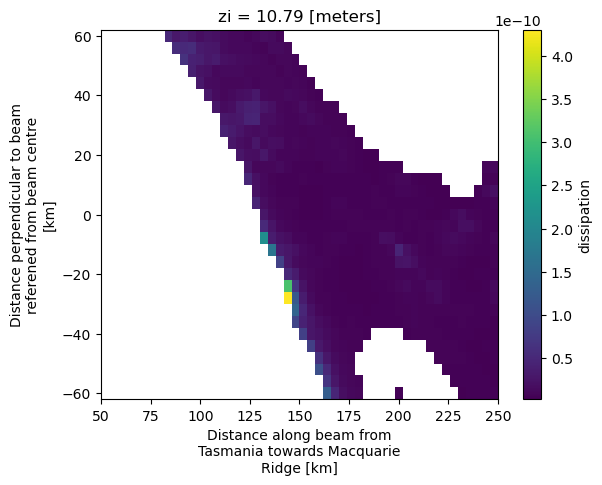

In [12]:
ShelfMask(dissipation["full-20"]).dissipation.mean("zl").plot()

## Plot dissipation with energy flux

/jobfs/135802465.gadi-pbs/ipykernel_2226560/2790719287.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdbu_cmap = matplotlib.cm.get_cmap("RdBu_r")


Experiment          Full from Beamless (%)   Smooth from Full (%)     
----------------------------------------------------------------------
10th:               26.81                    1.84                     
20th:               41.0                     126.47                   
40th:               19.2                     123.57                   
----------------------------------------------------------------------
Experiment          Full (mW/m2)             Beamless (mW/m2)         
10th:               0.0358                   0.0282                   
20th:               0.019                    0.0135                   
40th:               0.0362                   0.0304                   


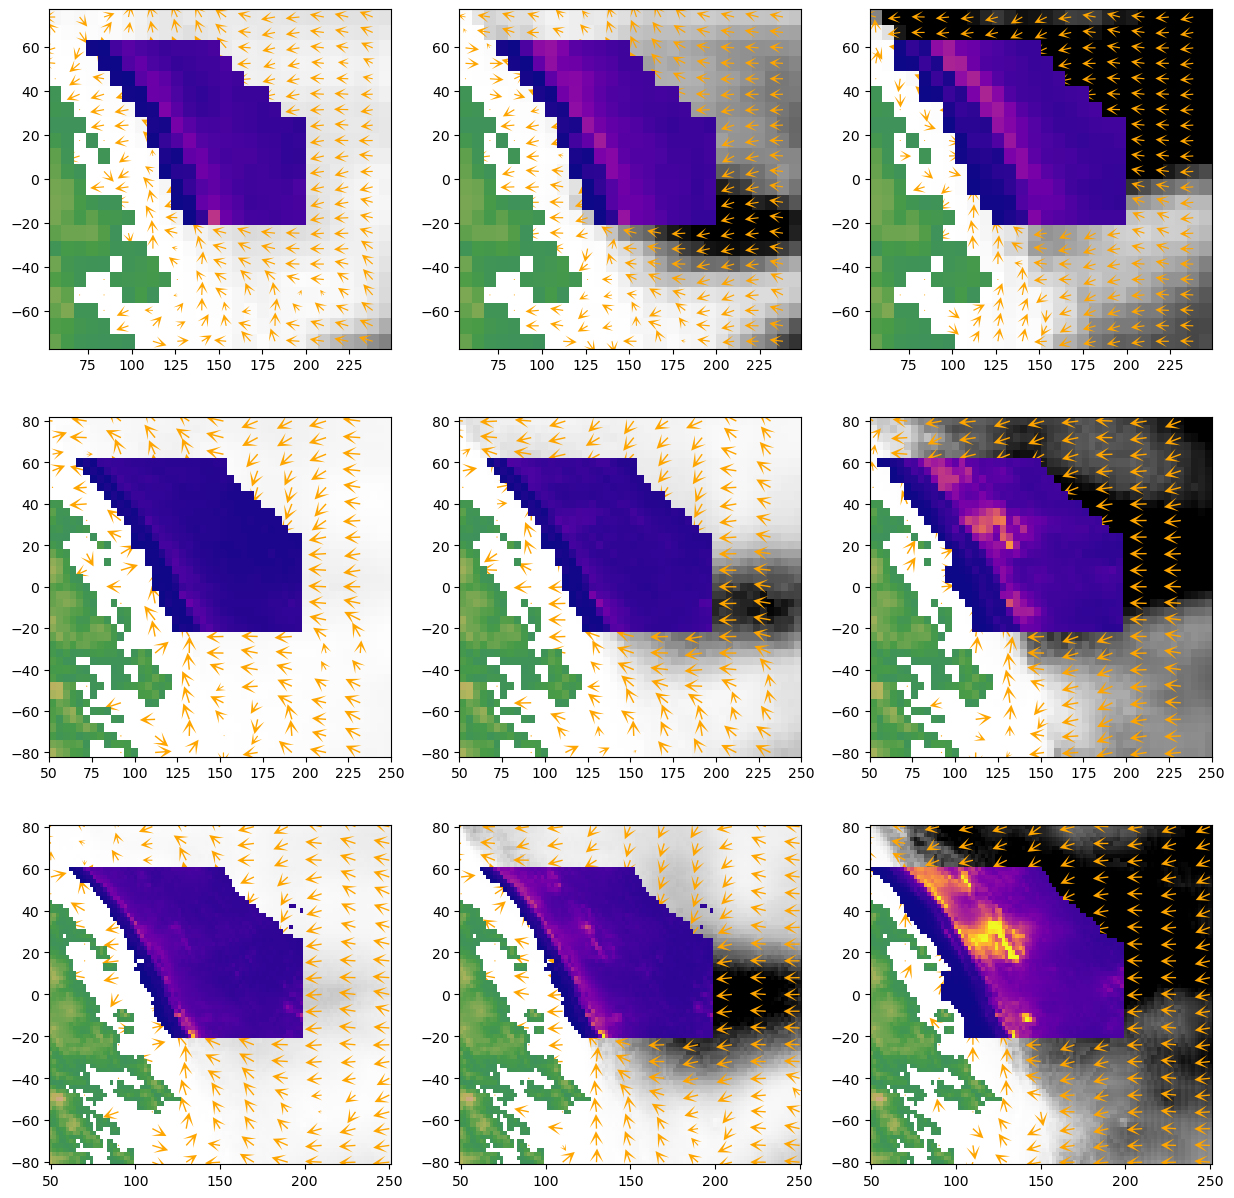

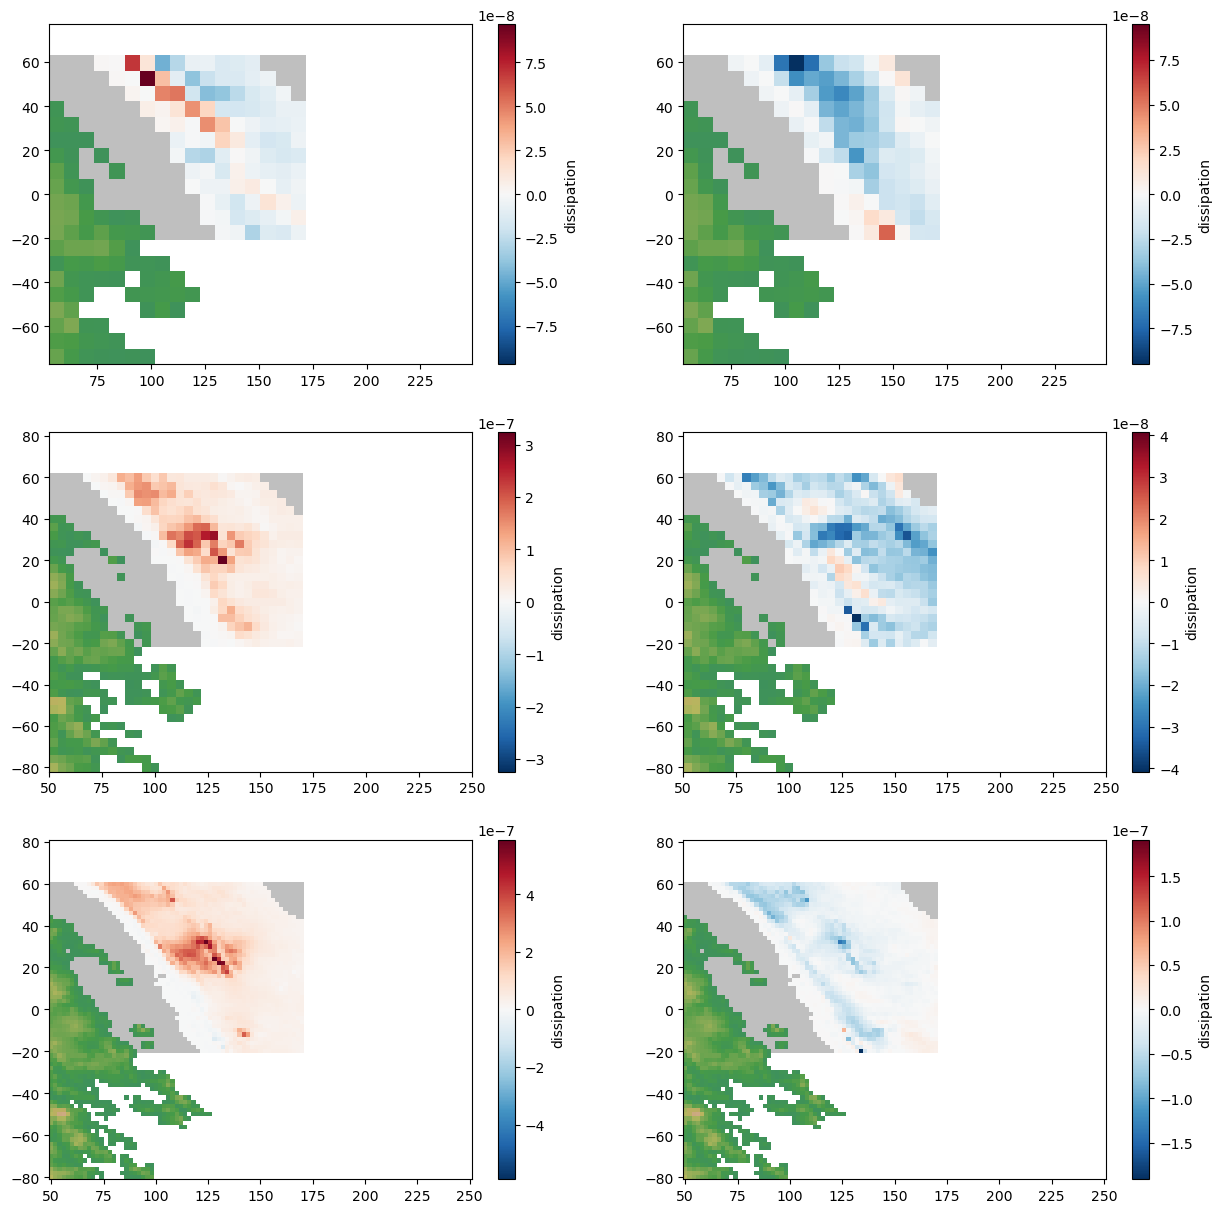

In [22]:
def ShelfMask(data):
    return data.where(
        ((data.bathy) < 4000) & (data.xb < 200) & (data.bathy > 100),np.nan
    ).sel(yb = slice(-20,60),zl = slice(100,None))


def plot_KE_quiver(expt,ax,xlim = slice(50,250),ylim = slice(-80,80)):
    # expt = "full-20"
    alongbeam = -1 * xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_forward.nc").EF_forward + xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_backward.nc").EF_backward
    acrossbeam = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_forward.nc").EF_forward + xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_backward.nc").EF_backward
    alongbeam = alongbeam.sel(xb = xlim,yb = ylim)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim)
    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    magnitude = np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode")

    if "10" in expt:
        vmax = 10
        _yb = acrossbeam.yb[::1]
        _xb = acrossbeam.xb[::2]
        _along = (alongbeam / magnitude).sum("mode")[::1,::2]
        _across = (acrossbeam / magnitude).sum("mode")[::1,::2]
    elif "20" in expt:
        vmax = 60
        _yb = acrossbeam.yb[::2]
        _xb = acrossbeam.xb[::5]
        _along = (alongbeam / magnitude).sum("mode")[::2,::5]
        _across = (acrossbeam / magnitude).sum("mode")[::2,::5]
    elif "40" in expt:
        vmax = 80
        _yb = acrossbeam.yb[::4]
        _xb = acrossbeam.xb[::10]
        _along = 2 * (alongbeam / magnitude).sum("mode")[::4,::10]
        _across = 2 * (acrossbeam / magnitude).sum("mode")[::4,::10]
    # print(expt,np.mean(magnitude.sel(xb = slice(100,175)).values),sep = "\t")

    magnitude.plot(ax = ax,cmap ="Greys",vmax = vmax,add_colorbar = False)
    # print(magnitude)

    ax.quiver(_xb, _yb, _along, _across,color = "orange",headwidth = 10,headlength = 10)
cmap = cmocean.cm.solar
names = ["FULL","SMOOTH","BEAMLESS"]
fig,ax = plt.subplots(3,3,figsize = (15,15))

totals = {}

for j,i in enumerate(["beamless-10","full-10","smooth-10"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    plot_KE_quiver(i,ax[0,j])
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[0,j],vmin = 0,vmax = 10,add_colorbar = True,cmap = "Greys")
    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[0,j],add_colorbar = True,cmap = "Greys_r")
    to_plot = ShelfMask(dissipation[i]).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,200)) * 1000 #adjust for density
    totals[i] = to_plot.mean("xb").mean("yb").values 
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[0,j],add_colorbar = False,vmax = 5e-4,cmap = "plasma")
    tt.plot_topo(ax[0,j],-1 * dissipation["full-10"].bathy)
    ax[0,j].set_title(f"")
    ax[0,j].set_ylabel("")
    ax[0,j].set_xlabel("")
for j,i in enumerate(["beamless-20","full-20","smooth-20"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[1,j],vmin = 0,vmax = 40,add_colorbar = True,cmap = "Greys")
    plot_KE_quiver(i,ax[1,j])

    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[1,j],add_colorbar = True,cmap = "Greys_r")
    to_plot = ShelfMask(dissipation[i]).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,200)) * 1000 #adjust for density
    totals[i] = to_plot.mean("xb").mean("yb").values 
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[1,j],add_colorbar = False,vmax = 5e-4,cmap = "plasma")
    tt.plot_topo(ax[1,j],-1 * dissipation["full-20"].bathy)
    ax[1,j].set_title(f"")
    ax[1,j].set_ylabel("")
    ax[1,j].set_xlabel("")
for j,i in enumerate(["beamless-40","full-40","smooth-40"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[2,j],vmin = 0,vmax = 50,add_colorbar = True,cmap = "Greys")
    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[2,j],add_colorbar = True,cmap = "Greys_r")
    plot_KE_quiver(i,ax[2,j])

    to_plot = ShelfMask(dissipation[i]).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,200)) * 1000 #adjust for density
    totals[i] = to_plot.mean("xb").mean("yb").values 
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[2,j],add_colorbar = False,vmax = 5e-4,cmap = "plasma")
    tt.plot_topo(ax[2,j],-1 * dissipation["full-40"].bathy)
    ax[2,j].set_ylabel("")
    ax[2,j].set_xlabel("")
    ax[2,j].set_title(f"")


rdbu_cmap = matplotlib.cm.get_cmap("RdBu_r")
rdbu_cmap.set_bad(color = "grey",alpha = 0.5)


# names = ["SMOOTH","BEAMLESS"]
# vmax = [0.01,0.002]
# fig,ax = plt.subplots(3,2,figsize = (15,15))
# for j,i in enumerate(["smooth-10","beamless-10"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-10"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     out.where(out != 0,np.nan).plot(ax = ax[0,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[0,j].set_title(f"")
#     ax[0,j].set_ylabel("")
#     ax[0,j].set_xlabel("")
#     ax[0,j].invert_yaxis()
# for j,i in enumerate(["smooth-20","beamless-20"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-20"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     out.where(out != 0,np.nan).plot(ax = ax[1,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[1,j].set_title(f"")
#     ax[1,j].set_ylabel("")
#     ax[1,j].set_xlabel("")
#     ax[1,j].invert_yaxis()
# for j,i in enumerate(["smooth-40","beamless-40"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-40"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     # out.where(out == 0,1).plot(ax = ax[2,j],cmap = "Greys_r")
    
#     out.where(out != 0,np.nan).plot(ax = ax[2,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[2,j].set_ylabel("")
#     ax[2,j].set_xlabel("")
#     ax[2,j].invert_yaxis()
#     ax[2,j].set_title(f"")

names = ["SMOOTH","BEAMLESS"]
vmax = [0.25,0.25]
fig,ax = plt.subplots(3,2,figsize = (15,15))
for j,i in enumerate(["smooth-10","beamless-10"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-10"])).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,170))
    out.where(out != 0,np.nan).plot(ax = ax[0,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[0,j],-1 * dissipation["full-10"].bathy)

    ax[0,j].set_title(f"")
    ax[0,j].set_ylabel("")
    ax[0,j].set_xlabel("")

for j,i in enumerate(["smooth-20","beamless-20"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-20"])).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,170))
    out.where(out != 0,np.nan).plot(ax = ax[1,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[1,j],-1 * dissipation["full-20"].bathy)
    ax[1,j].set_title(f"")
    ax[1,j].set_ylabel("")
    ax[1,j].set_xlabel("")

for j,i in enumerate(["smooth-40","beamless-40"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-40"])).dissipation.fillna(0).integrate("zl").sel(xb = slice(50,170))
    # out.where(out == 0,1).plot(ax = ax[2,j],cmap = "Greys_r")
    
    out.where(out != 0,np.nan).plot(ax = ax[2,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[2,j],-1 * dissipation["full-40"].bathy)

    ax[2,j].set_ylabel("")
    ax[2,j].set_xlabel("")
    ax[2,j].set_title(f"")

print(f"{'Experiment':<20}{'Full from Beamless (%)':<25}{'Smooth from Full (%)':<25}")
print(f"{'-'*70}")
print(f"{'10th:':<20}{np.round((totals['full-10'] - totals['beamless-10']) / totals['beamless-10'] * 100, 2):<25}{np.round((totals['smooth-10'] - totals['full-10']) / totals['full-10'] * 100, 2):<25}")
print(f"{'20th:':<20}{np.round((totals['full-20'] - totals['beamless-20']) / totals['beamless-20'] * 100, 2):<25}{np.round((totals['smooth-20'] - totals['full-20']) / totals['full-20'] * 100, 2):<25}")
print(f"{'40th:':<20}{np.round((totals['full-40'] - totals['beamless-40']) / totals['beamless-40'] * 100, 2):<25}{np.round((totals['smooth-40'] - totals['full-40']) / totals['full-40'] * 100, 2):<25}")
print(f"{'-'*70}")
print(f"{'Experiment':<20}{'Full (mW/m2)':<25}{'Beamless (mW/m2)':<25}")
print(f"{'10th:':<20}{np.round(totals['full-10'] * 1000, 4):<25}{np.round(totals['beamless-10'] * 1000 , 4):<25}")
print(f"{'20th:':<20}{np.round(totals['full-20'] * 1000, 4):<25}{np.round(totals['beamless-20'] * 1000 , 4):<25}")
print(f"{'40th:':<20}{np.round(totals['full-40'] * 1000, 4):<25}{np.round(totals['beamless-40'] * 1000 , 4):<25}")



In [55]:
totals["smooth-10"]

327.297

In [21]:
diss10 = [36.872,56.331,72.859]
diss20 = [64.339,92.151,253.913]
diss40 = [207.572,301.175,717.337]

print("10th increase in dissipation: \tfull from beamless\t",np.round((diss10[1] - diss10[0]) / diss10[0] * 100,2),"%\t","smooth from full\t",np.round((diss10[2] - diss10[1]) / diss10[1] * 100,2),"%")
print("20th increase in dissipation: \tfull from beamless\t",np.round((diss20[1] - diss20[0]) / diss20[0] * 100,2),"%\t","smooth from full\t",np.round((diss20[2] - diss20[1]) / diss20[1] * 100,2),"%")
print("40th increase in dissipation: \tfull from beamless\t",np.round((diss40[1] - diss40[0]) / diss40[0] * 100,2),"%\t","smooth from full\t",np.round((diss40[2] - diss40[1]) / diss40[1] * 100,2),"%")

10th increase in dissipation: 	full from beamless	 52.77 %	 smooth from full	 29.34 %
20th increase in dissipation: 	full from beamless	 43.23 %	 smooth from full	 175.54 %
40th increase in dissipation: 	full from beamless	 45.09 %	 smooth from full	 138.18 %


## Bar plot of dissipation:

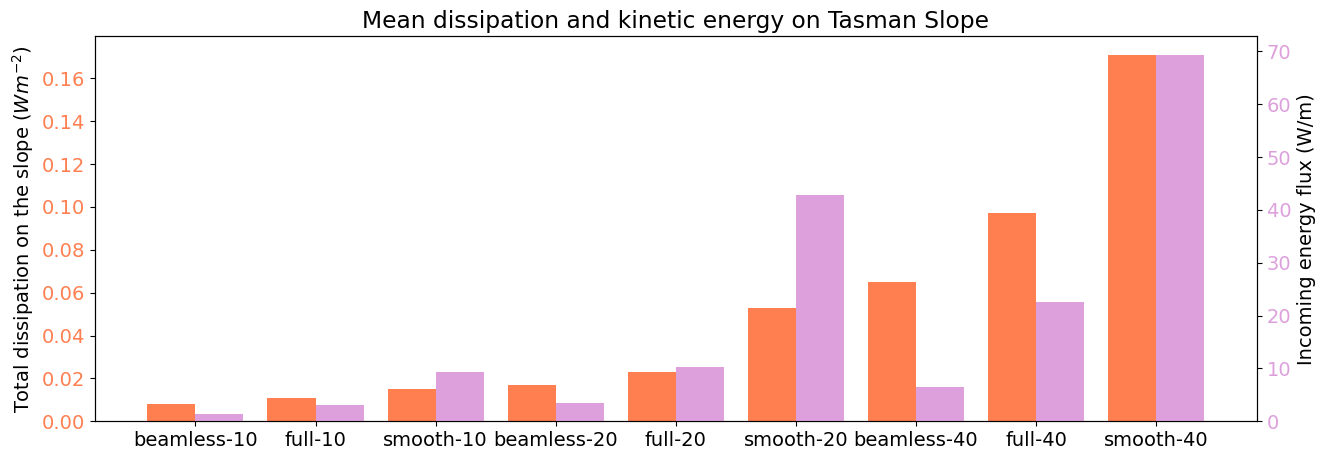

In [6]:
diss10 = np.sort([0.011,0.015,0.008])
diss20 = np.sort([0.023,0.053,0.017])
diss40 = np.sort([0.097,0.171,0.065])

ef10 = np.sort([3.0457662134888253,9.261021739977888,1.3631641926455662])
ef20 = np.sort([10.216887688220766,42.77777804710803,3.417172848927735])
ef40 = np.sort([22.542798919136057,69.37130439711467,6.411489438930214,])

labels = ["beamless-10","full-10","smooth-10","beamless-20","full-20","smooth-20","beamless-40","full-40","smooth-40"]
plt.rcParams.update({'font.size': 14})

# Sample data
x = np.arange(len(labels))
y1 = np.concatenate([diss10, diss20, diss40])
y2 = np.concatenate([ef10, ef20, ef40])

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(1,figsize=(15, 5))

# Plot the first bar plot
bar_width = 0.4
ax1.bar(x - bar_width/2, y1, bar_width, label='Y1', color='coral')
ax1.set_ylabel(r'Total dissipation on the slope ($W m^{-2}$)', color='black')


ax1.tick_params(axis='y', labelcolor='coral')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.bar(x + bar_width/2, y2, bar_width, label='Y2', color='plum')
ax2.set_ylabel('Incoming energy flux (W/m)', color='black')
ax2.tick_params(axis='y', labelcolor='plum')

# Set x-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# Add a title
plt.title('Mean dissipation and kinetic energy on Tasman Slope')

# Show the plot
plt.show()

# Same but for the seamount

In [3]:

full10 = calculate_dissipation("full-10",22000,xb = slice(214,456),yb = slice(-104,44))
beamless10 = calculate_dissipation("beamless-10",22000,xb = slice(214,456),yb = slice(-104,44))
smooth10 = calculate_dissipation("smooth-10",22000,xb = slice(214,456),yb = slice(-104,46))
full20 = calculate_dissipation("full-20",22000,xb = slice(214,456),yb = slice(-100,48))
beamless20 = calculate_dissipation("beamless-20",22000,xb = slice(214,456),yb = slice(-100,48))
smooth20 = calculate_dissipation("smooth-20",22000,xb = slice(214,456),yb = slice(-100,48))
full40 = calculate_dissipation("full-40",4216,xb = slice(214,456),yb = slice(-104,44))
beamless40 = calculate_dissipation("beamless-40",4216,xb = slice(214,456),yb = slice(-104,44))
smooth40 = calculate_dissipation("smooth-40",4216,xb = slice(214,456),yb = slice(-104,44))

full10.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/full10.nc")
beamless10.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/beamless10.nc")
smooth10.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/smooth10.nc")
full20.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/full20.nc")
beamless20.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/beamless20.nc")
smooth20.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/smooth20.nc")
full40.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/full40.nc")
beamless40.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/beamless40.nc")
smooth40.to_netcdf("/g/data/nm03/ab8992/postprocessed/seamount_dissipation/smooth40.nc")

loading ahh...	done.
loading u...	done.
loading v...	done.
loading ahh...	done.
loading u...	done.
loading v...	done.
loading ahh...	done.
loading u...	done.
loading v...	done.
loading ahh...	done.
loading u...	done.
loading v...	done.


2025-02-20 15:52:30,033 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.21 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:52:30,289 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.34 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:52:30,672 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.30 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:52:30,947 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 2.31 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:52:35,658 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:52:36,731 - distributed.worker.memory - WARNING - Worker is at 50% memory usage. Resuming worker. Process memory: 2.04 GiB -- Worker mem

loading ahh...	done.
loading u...	done.
loading v...	done.


2025-02-20 15:53:29,780 - distributed.worker.memory - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 3.40 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:53:30,481 - distributed.worker.memory - WARNING - Worker is at 54% memory usage. Resuming worker. Process memory: 2.19 GiB -- Worker memory limit: 4.00 GiB


loading ahh...	done.
loading u...	done.
loading v...	done.


2025-02-20 15:54:25,777 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.27 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:54:25,847 - distributed.worker.memory - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 3.41 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:54:26,023 - distributed.worker.memory - WARNING - Worker is at 54% memory usage. Resuming worker. Process memory: 2.19 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:54:26,482 - distributed.worker.memory - WARNING - Worker is at 62% memory usage. Resuming worker. Process memory: 2.51 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:54:27,961 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.25 GiB -- Worker memory limit: 4.00 GiB
2025-02-20 15:54:28,344 - distributed.worker.memory - WARNING - Worker is at 60% memory usage. Resuming worker. Process memory: 2.43 GiB -- Worker mem

loading ahh...	done.
loading u...	done.
loading v...	done.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 19.16 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


loading ahh...	done.
loading u...	done.
loading v...	done.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 13.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


loading ahh...	done.
loading u...	done.
loading v...	done.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 20.88 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [7]:
EF_forward = {}
EF_backward = {}
dissipation = {}
KE_modal = {}
for expt in expts:
    EF_forward[expt] = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_forward.nc")
    EF_backward[expt] = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_backward.nc")
    dissipation[expt] = xr.open_dataset(f"/g/data/nm03/ab8992/postprocessed/seamount_dissipation/{expt.split('-')[0] + expt.split('-')[1]}.nc")
    KE_modal[expt] = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/ke_modal.nc")

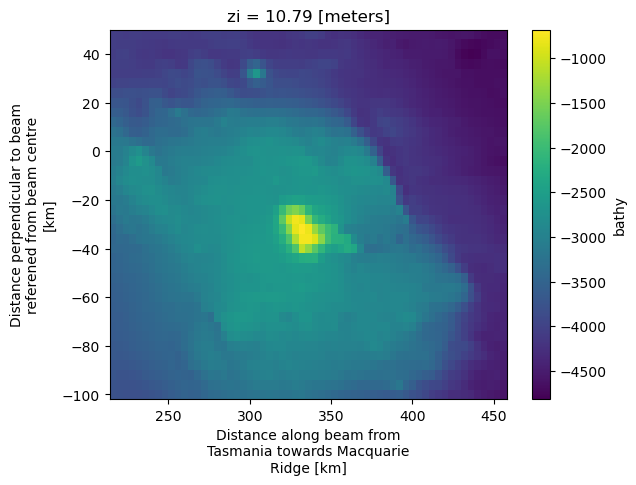

In [26]:
dissipation["beamless-20"].bathy.plot()

0.0004562879


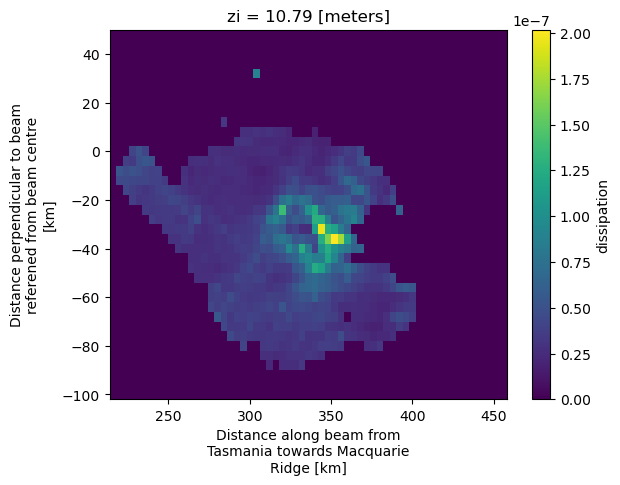

In [41]:
to_plot = ShelfMask(dissipation["full-20"]).fillna(0).dissipation.integrate("zl")
print(np.round(to_plot.fillna(0).integrate("xb").integrate("yb").values,10))
to_plot.plot()

/jobfs/135639937.gadi-pbs/ipykernel_339611/3417922031.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rdbu_cmap = matplotlib.cm.get_cmap("RdBu_r")


Experiment          Full from Beamless (%)   Smooth from Full (%)     
----------------------------------------------------------------------
10th:               0.6957                   -100.0                   
20th:               51.89381                 -100.0                   
40th:               5.21563                  -100.0                   


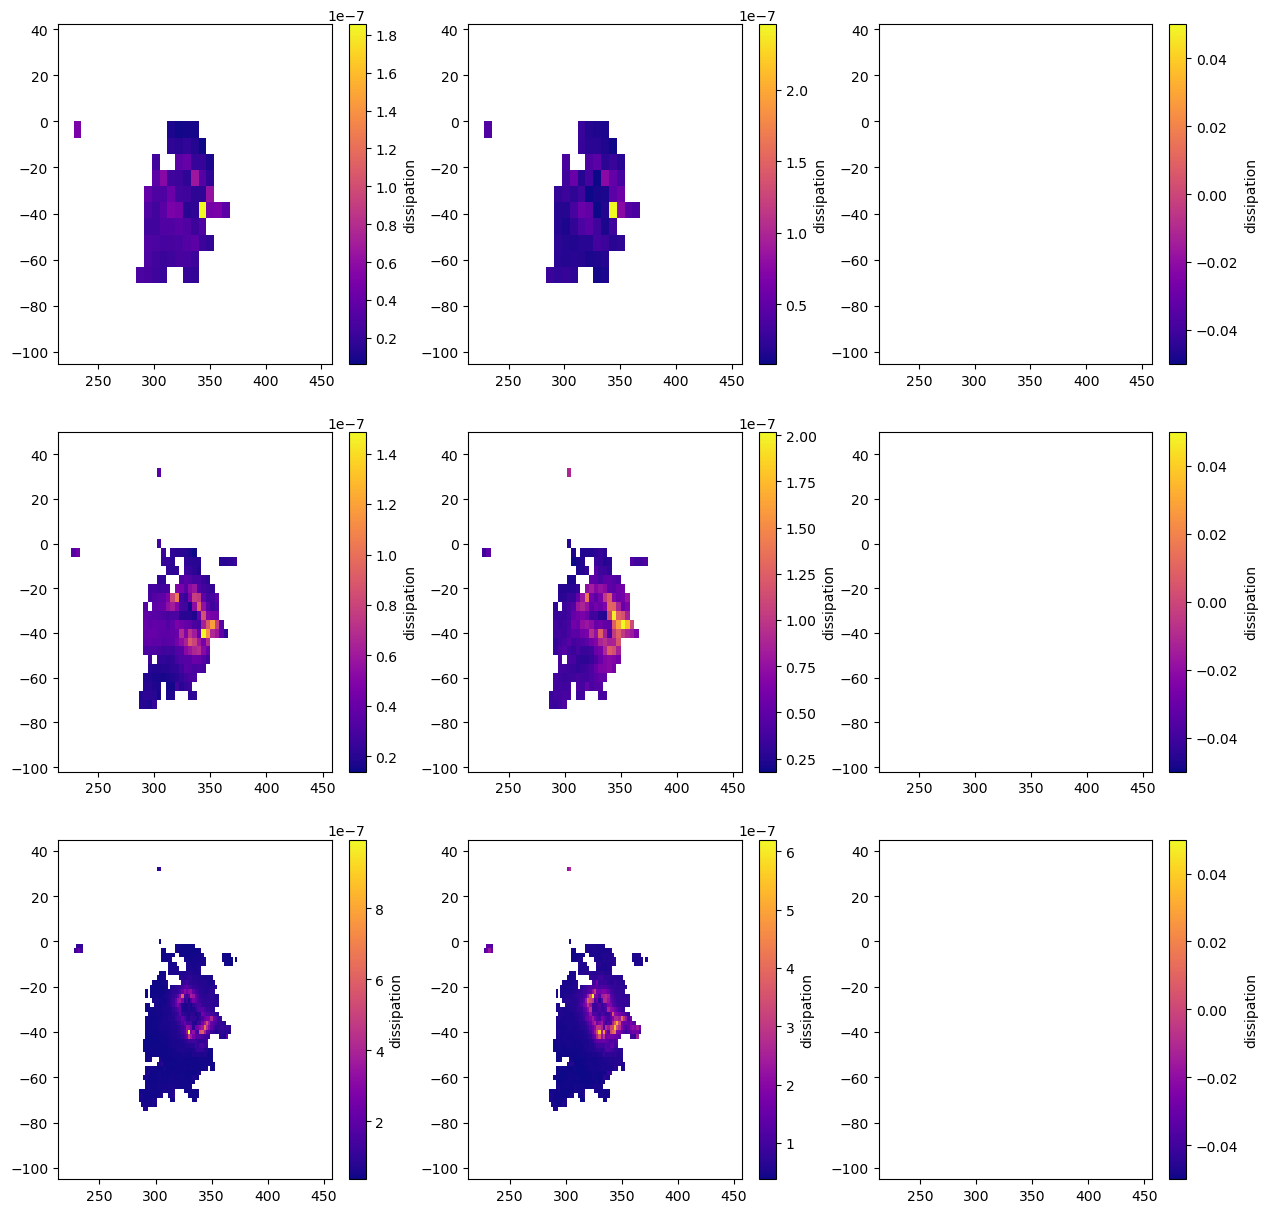

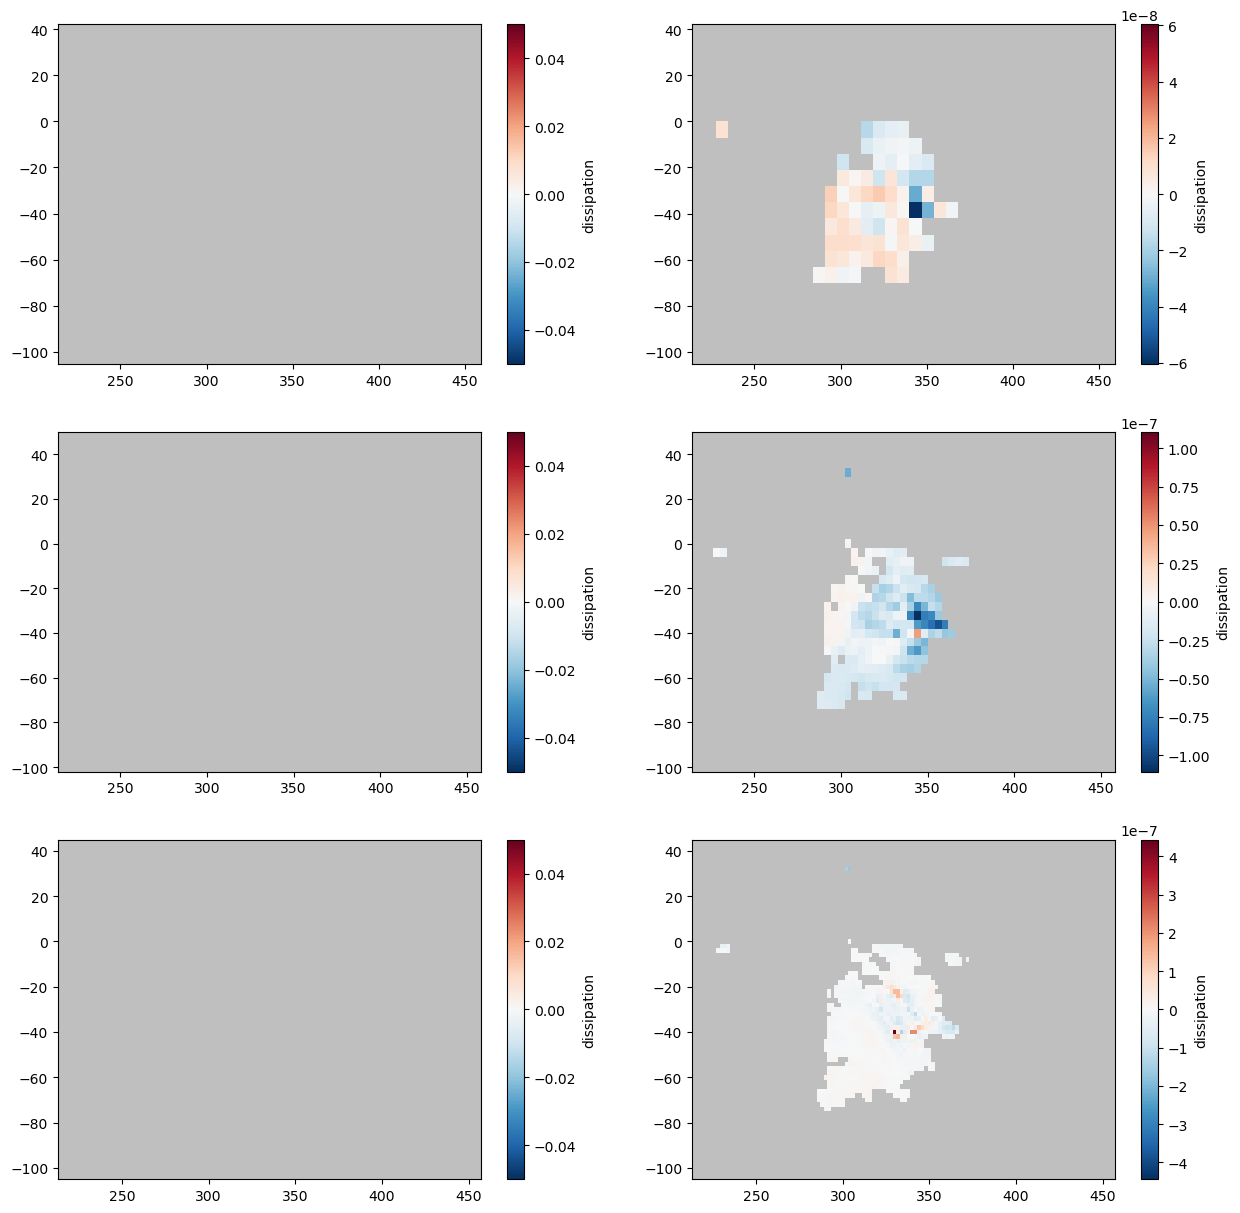

In [51]:
def ShelfMask(data):
    return data.where(
        (np.abs(data.bathy) < 2700) & (np.abs(data.bathy) > 50),np.nan
    ).sel(yb = slice(-200,200),zl = slice(50,None))


def plot_KE_quiver(expt,ax,xlim = slice(None,250),ylim = slice(-80,80)):
    # expt = "full-20"
    alongbeam = -1 * xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_forward.nc").EF_forward + xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_backward.nc").EF_backward
    acrossbeam = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_forward.nc").EF_forward + xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_backward.nc").EF_backward
    alongbeam = alongbeam.sel(xb = xlim,yb = ylim)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim)
    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    magnitude = np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode")

    if "10" in expt:
        vmax = 10
        _yb = acrossbeam.yb[::1]
        _xb = acrossbeam.xb[::2]
        _along = (alongbeam / magnitude).sum("mode")[::1,::2]
        _across = (acrossbeam / magnitude).sum("mode")[::1,::2]
    elif "20" in expt:
        vmax = 60
        _yb = acrossbeam.yb[::2]
        _xb = acrossbeam.xb[::5]
        _along = (alongbeam / magnitude).sum("mode")[::2,::5]
        _across = (acrossbeam / magnitude).sum("mode")[::2,::5]
    elif "40" in expt:
        vmax = 80
        _yb = acrossbeam.yb[::4]
        _xb = acrossbeam.xb[::10]
        _along = 2 * (alongbeam / magnitude).sum("mode")[::4,::10]
        _across = 2 * (acrossbeam / magnitude).sum("mode")[::4,::10]
    # print(expt,np.mean(magnitude.sel(xb = slice(100,175)).values),sep = "\t")

    magnitude.plot(ax = ax,cmap ="Greys",vmax = vmax,add_colorbar = False)
    # print(magnitude)

    ax.quiver(_xb, _yb, _along, _across,color = "orange",headwidth = 10,headlength = 10)
cmap = cmocean.cm.solar
names = ["FULL","SMOOTH","BEAMLESS"]
fig,ax = plt.subplots(3,3,figsize = (15,15))

totals = {}

for j,i in enumerate(["beamless-10","full-10","smooth-10"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    # plot_KE_quiver(i,ax[0,j])
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[0,j],vmin = 0,vmax = 10,add_colorbar = True,cmap = "Greys")
    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[0,j],add_colorbar = True,cmap = "Greys_r")
    to_plot = ShelfMask(dissipation[i]).dissipation.integrate("zl")
    totals[i] = to_plot.fillna(0).integrate("xb").integrate("yb").values
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[0,j],add_colorbar = True,cmap = "plasma")
    tt.plot_topo(ax[0,j],dissipation["full-10"].bathy)
    ax[0,j].set_title(f"")
    ax[0,j].set_ylabel("")
    ax[0,j].set_xlabel("")
for j,i in enumerate(["beamless-20","full-20","smooth-20"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[1,j],vmin = 0,vmax = 40,add_colorbar = True,cmap = "Greys")
    # plot_KE_quiver(i,ax[1,j])

    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[1,j],add_colorbar = True,cmap = "Greys_r")
    to_plot = ShelfMask(dissipation[i]).dissipation.integrate("zl")
    totals[i] = to_plot.fillna(0).integrate("xb").integrate("yb").values
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[1,j],add_colorbar = True,cmap = "plasma")
    tt.plot_topo(ax[1,j],dissipation["full-20"].bathy)
    ax[1,j].set_title(f"")
    ax[1,j].set_ylabel("")
    ax[1,j].set_xlabel("")
for j,i in enumerate(["beamless-40","full-40","smooth-40"]):
    # v = round(float(ShelfMask(dissipation[i]).dissipation.integrate("zl").mean("xb").mean("yb").values),3)
    # EF_forward[i].EF_forward.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[2,j],vmin = 0,vmax = 50,add_colorbar = True,cmap = "Greys")
    # KE_modal[i].KE_modal.isel(mode = slice(0,None)).sum("mode").sel(xb = slice(50,250)).plot(ax = ax[2,j],add_colorbar = True,cmap = "Greys_r")
    # plot_KE_quiver(i,ax[2,j])

    to_plot = ShelfMask(dissipation[i]).dissipation.fillna(0).integrate("zl")
    totals[i] = to_plot.fillna(0).integrate("xb").integrate("yb").values
    to_plot.where(to_plot != 0,np.nan).plot(ax = ax[2,j],add_colorbar = True,cmap = "plasma")
    tt.plot_topo(ax[2,j],dissipation["full-40"].bathy)
    ax[2,j].set_ylabel("")
    ax[2,j].set_xlabel("")
    ax[2,j].set_title(f"")


rdbu_cmap = matplotlib.cm.get_cmap("RdBu_r")
rdbu_cmap.set_bad(color = "grey",alpha = 0.5)


# names = ["SMOOTH","BEAMLESS"]
# vmax = [0.01,0.002]
# fig,ax = plt.subplots(3,2,figsize = (15,15))
# for j,i in enumerate(["smooth-10","beamless-10"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-10"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     out.where(out != 0,np.nan).plot(ax = ax[0,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[0,j].set_title(f"")
#     ax[0,j].set_ylabel("")
#     ax[0,j].set_xlabel("")
#     ax[0,j].invert_yaxis()
# for j,i in enumerate(["smooth-20","beamless-20"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-20"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     out.where(out != 0,np.nan).plot(ax = ax[1,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[1,j].set_title(f"")
#     ax[1,j].set_ylabel("")
#     ax[1,j].set_xlabel("")
#     ax[1,j].invert_yaxis()
# for j,i in enumerate(["smooth-40","beamless-40"]):
#     out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-40"])).dissipation.fillna(0).integrate("yb").sel(xb = slice(50,200))
#     # out.where(out == 0,1).plot(ax = ax[2,j],cmap = "Greys_r")
    
#     out.where(out != 0,np.nan).plot(ax = ax[2,j],add_colorbar = True,vmax = vmax[j],vmin = -vmax[j],cmap = rdbu_cmap)
#     ax[2,j].set_ylabel("")
#     ax[2,j].set_xlabel("")
#     ax[2,j].invert_yaxis()
#     ax[2,j].set_title(f"")

names = ["SMOOTH","BEAMLESS"]
vmax = [0.25,0.25]
fig,ax = plt.subplots(3,2,figsize = (15,15))
for j,i in enumerate(["smooth-10","beamless-10"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-10"])).dissipation.fillna(0).integrate("zl")
    out.where(out != 0,np.nan).plot(ax = ax[0,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[0,j],dissipation["full-10"].bathy)

    ax[0,j].set_title(f"")
    ax[0,j].set_ylabel("")
    ax[0,j].set_xlabel("")

for j,i in enumerate(["smooth-20","beamless-20"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-20"])).dissipation.fillna(0).integrate("zl")
    out.where(out != 0,np.nan).plot(ax = ax[1,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[1,j],dissipation["full-20"].bathy)
    ax[1,j].set_title(f"")
    ax[1,j].set_ylabel("")
    ax[1,j].set_xlabel("")

for j,i in enumerate(["smooth-40","beamless-40"]):
    out = (ShelfMask(dissipation[i]) - ShelfMask(dissipation["full-40"])).dissipation.fillna(0).integrate("zl")
    # out.where(out == 0,1).plot(ax = ax[2,j],cmap = "Greys_r")
    
    out.where(out != 0,np.nan).plot(ax = ax[2,j],add_colorbar = True,cmap = rdbu_cmap)
    tt.plot_topo(ax[2,j], dissipation["full-40"].bathy)

    ax[2,j].set_ylabel("")
    ax[2,j].set_xlabel("")
    ax[2,j].set_title(f"")

print(f"{'Experiment':<20}{'Full from Beamless (%)':<25}{'Smooth from Full (%)':<25}")
print(f"{'-'*70}")
print(f"{'10th:':<20}{np.round((totals['full-10'] - totals['beamless-10']) / totals['beamless-10'] * 100, 5):<25}{np.round((totals['smooth-10'] - totals['full-10']) / totals['full-10'] * 100, 5):<25}")
print(f"{'20th:':<20}{np.round((totals['full-20'] - totals['beamless-20']) / totals['beamless-20'] * 100, 5):<25}{np.round((totals['smooth-20'] - totals['full-20']) / totals['full-20'] * 100, 5):<25}")
print(f"{'40th:':<20}{np.round((totals['full-40'] - totals['beamless-40']) / totals['beamless-40'] * 100, 5):<25}{np.round((totals['smooth-40'] - totals['full-40']) / totals['full-40'] * 100, 5):<25}")
